<a href="https://colab.research.google.com/github/sahilbaishya/HumanEmotionsDetection/blob/main/HumanEmotionsDetection_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import tensorflow_probability as tfp

from tensorflow.keras.regularizers  import L2, L1
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)

from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model


from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy

from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)

#for tensorflow records
from tensorflow.train import BytesList, Int64List, FloatList
from tensorflow.train import Example, Features, Feature

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy


In [11]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

CLASS_NAMES = ["angry", "happy", "sad"]
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 0.001,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 100,
    "N_DENSE_2": 10,
    "NUM_CLASSES": 3,
}

# Data Management

## Data Downloading

In [12]:
!pip install -q kaggle

In [13]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [14]:
!chmod 600 /root/.kaggle/kaggle.json

In [15]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

100% 309M/309M [00:15<00:00, 22.0MB/s]
100% 309M/309M [00:15<00:00, 20.5MB/s]


In [ ]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset"

## Dataset Loading


In [17]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [18]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


## Dataset Visualization

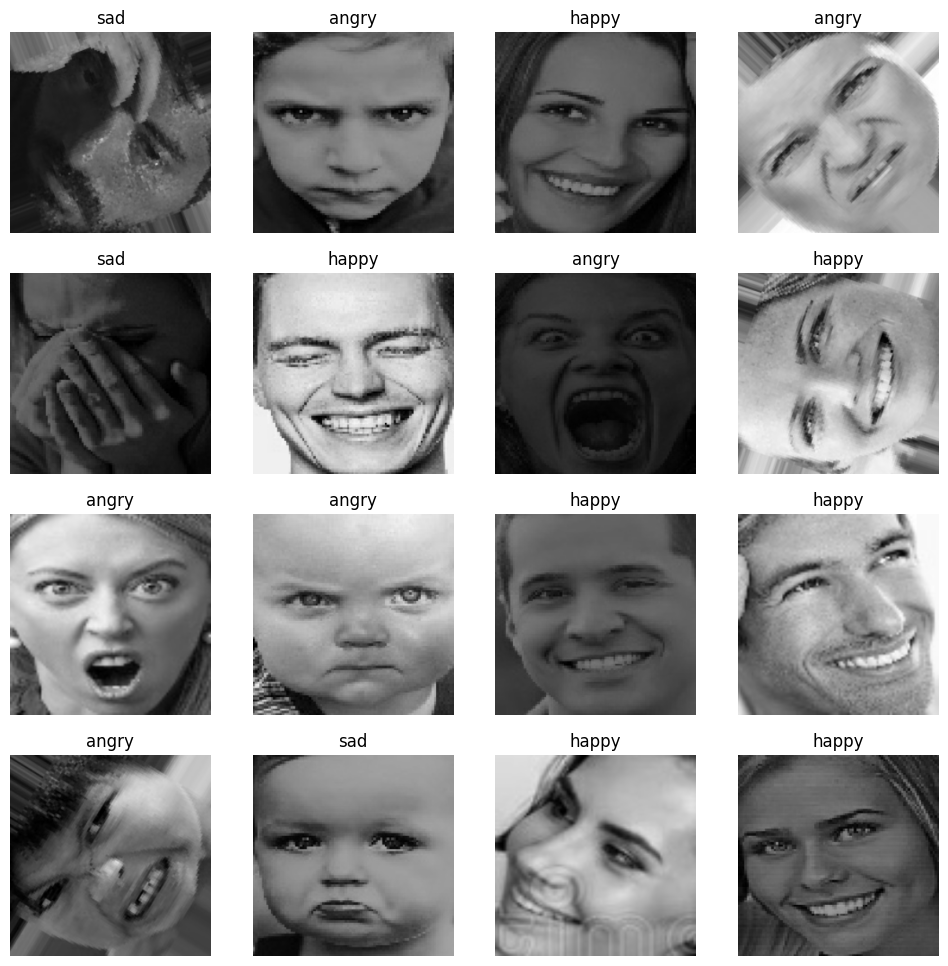

In [19]:
plt.figure(figsize = (12, 12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

# Augmentation

## Data Augmentation

In [32]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor = (-0.025, 0.025)),
    RandomFlip(mode = 'horizontal',),
    RandomContrast(factor = 0.1),
])

In [33]:
def augment_layer(image, label):
  return augment_layers(image, training=True), label

## Cutmix Augmentation


In [13]:
def box(lamda):

  IM_SIZE = 256
  r_x = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, IM_SIZE).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(IM_SIZE*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, IM_SIZE)
  r_y = tf.clip_by_value(r_y - r_h//2, 0, IM_SIZE)

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, IM_SIZE)
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, IM_SIZE)

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

In [14]:
def cutmix(train_dataset_1, train_dataset_2):
  IM_SIZE = 256
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(0.2,0.2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, IM_SIZE, IM_SIZE)

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, IM_SIZE, IM_SIZE)

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(IM_SIZE*IM_SIZE), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

## Dataset Preparation

In [34]:
#For normal augmentation
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    # .prefetch(tf.data.AUTOTUNE)
)

In [16]:
#for cutmix augmentation
# train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
# train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

# mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [17]:
#For cutmix augmentation
# training_dataset = (
#     mixed_dataset
#     .map(cutmix, num_parallel_calls = tf.data.AUTOTUNE)
#     .prefetch(tf.data.AUTOTUNE)
# )

In [35]:
val_dataset = (
    validation_dataset
    # .prefetch(tf.data.AUTOTUNE)
)

In [36]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    Rescaling(1.0/255),
])

# Modeling

## Lenet


In [20]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3) ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)     

## ResNET


### Custom Conv2D Block

In [5]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)

    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

### Residual Block

In [6]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)

  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

### Network

In [9]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')

    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)

    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)

    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)

    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')

  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)

    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)

    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)

    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)

    return self.fc_3(x)

In [26]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1, 256, 256, 3]), training = True)
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 9728      
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

### Train

In [29]:
# checkpoint_callback = ModelCheckpoint(
#     'weights.{epoch:02d}-Z{val_loss:.2f}.hdf5',
#     monitor='val_accuracy', verbose =1,
#     save_best_only = True
# ) ##THIS DOSENT WORK FOR SUBCLASSED MODELS, WORKS FOR SEQUENTION OR FUNCTIONAL MODELS

checkpoint_callback = ModelCheckpoint(
    'best_weights',
    monitor='val_accuracy',
    mode = 'max',
    verbose=1,
    save_best_only=True,

    )

In [30]:
loss_function = CategoricalCrossentropy()

In [27]:
metrics = [CategoricalAccuracy(name = "accuracy" ), TopKCategoricalAccuracy(k = 2, name = "top_k_accuracy")]

In [28]:
resnet_34.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']*10),
    loss = loss_function,
    metrics = metrics
)

In [37]:
history = resnet_34.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"]*3,
    verbose = 1,
    callbacks = [checkpoint_callback]
)

Epoch 1/60
213/213 [==============================] - ETA: 0s - loss: 1.4011 - accuracy: 0.4165 - top_k_accuracy: 0.7401
Epoch 1: val_accuracy improved from -inf to 0.44293, saving model to best_weights


213/213 [==============================] - 138s 476ms/step - loss: 1.4011 - accuracy: 0.4165 - top_k_accuracy: 0.7401 - val_loss: 20.5187 - val_accuracy: 0.4429 - val_top_k_accuracy: 0.7880
Epoch 2/60
213/213 [==============================] - ETA: 0s - loss: 1.0976 - accuracy: 0.4618 - top_k_accuracy: 0.7583
Epoch 2: val_accuracy did not improve from 0.44293
213/213 [==============================] - 72s 335ms/step - loss: 1.0976 - accuracy: 0.4618 - top_k_accuracy: 0.7583 - val_loss: 1.3697 - val_accuracy: 0.3323 - val_top_k_accuracy: 0.5931
Epoch 3/60
213/213 [==============================] - ETA: 0s - loss: 1.0697 - accuracy: 0.4945 - top_k_accuracy: 0.7782
Epoch 3: val_accuracy did not improve from 0.44293
213/213 [==============================] - 75s 352ms/step - loss: 1.0697 - accuracy: 0.4945 - top_k_accuracy: 0.7782 - val_loss: 1.1797 - val_accuracy: 0.4065 - val_top_k_accuracy: 0.7489
Epoch 4/60
213/213 [==============================] - ETA: 0s - loss: 1.0149 - accuracy: 0

213/213 [==============================] - 93s 431ms/step - loss: 0.9921 - accuracy: 0.5245 - top_k_accuracy: 0.8056 - val_loss: 1.0112 - val_accuracy: 0.5303 - val_top_k_accuracy: 0.7915
Epoch 6/60
213/213 [==============================] - ETA: 0s - loss: 0.9694 - accuracy: 0.5467 - top_k_accuracy: 0.8216
Epoch 6: val_accuracy did not improve from 0.53029
213/213 [==============================] - 87s 404ms/step - loss: 0.9694 - accuracy: 0.5467 - top_k_accuracy: 0.8216 - val_loss: 1.0363 - val_accuracy: 0.5189 - val_top_k_accuracy: 0.7871
Epoch 7/60
213/213 [==============================] - ETA: 0s - loss: 0.9346 - accuracy: 0.5683 - top_k_accuracy: 0.8320
Epoch 7: val_accuracy did not improve from 0.53029
213/213 [==============================] - 88s 412ms/step - loss: 0.9346 - accuracy: 0.5683 - top_k_accuracy: 0.8320 - val_loss: 2.5820 - val_accuracy: 0.3095 - val_top_k_accuracy: 0.6633
Epoch 8/60
213/213 [==============================] - ETA: 0s - loss: 0.8814 - accuracy: 0.5

213/213 [==============================] - 109s 508ms/step - loss: 0.7781 - accuracy: 0.6507 - top_k_accuracy: 0.8754 - val_loss: 1.0665 - val_accuracy: 0.5404 - val_top_k_accuracy: 0.8147
Epoch 11/60
213/213 [==============================] - ETA: 0s - loss: 0.7200 - accuracy: 0.6745 - top_k_accuracy: 0.8928
Epoch 11: val_accuracy improved from 0.54039 to 0.61501, saving model to best_weights


213/213 [==============================] - 100s 469ms/step - loss: 0.7200 - accuracy: 0.6745 - top_k_accuracy: 0.8928 - val_loss: 1.0236 - val_accuracy: 0.6150 - val_top_k_accuracy: 0.8411
Epoch 12/60
213/213 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.7000 - top_k_accuracy: 0.8987
Epoch 12: val_accuracy did not improve from 0.61501
213/213 [==============================] - 73s 338ms/step - loss: 0.6904 - accuracy: 0.7000 - top_k_accuracy: 0.8987 - val_loss: 1.2512 - val_accuracy: 0.5347 - val_top_k_accuracy: 0.7994
Epoch 13/60
213/213 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.7089 - top_k_accuracy: 0.9045
Epoch 13: val_accuracy did not improve from 0.61501
213/213 [==============================] - 71s 330ms/step - loss: 0.6565 - accuracy: 0.7089 - top_k_accuracy: 0.9045 - val_loss: 1.0289 - val_accuracy: 0.5198 - val_top_k_accuracy: 0.7713
Epoch 14/60
213/213 [==============================] - ETA: 0s - loss: 0.6383 - accurac

213/213 [==============================] - 95s 445ms/step - loss: 0.6383 - accuracy: 0.7266 - top_k_accuracy: 0.9109 - val_loss: 0.8382 - val_accuracy: 0.6602 - val_top_k_accuracy: 0.8705
Epoch 15/60
213/213 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.7395 - top_k_accuracy: 0.9215
Epoch 15: val_accuracy did not improve from 0.66023
213/213 [==============================] - 71s 331ms/step - loss: 0.6062 - accuracy: 0.7395 - top_k_accuracy: 0.9215 - val_loss: 1.1731 - val_accuracy: 0.5579 - val_top_k_accuracy: 0.7972
Epoch 16/60
213/213 [==============================] - ETA: 0s - loss: 0.5797 - accuracy: 0.7495 - top_k_accuracy: 0.9244
Epoch 16: val_accuracy did not improve from 0.66023
213/213 [==============================] - 70s 328ms/step - loss: 0.5797 - accuracy: 0.7495 - top_k_accuracy: 0.9244 - val_loss: 1.0236 - val_accuracy: 0.5149 - val_top_k_accuracy: 0.7897
Epoch 17/60
213/213 [==============================] - ETA: 0s - loss: 0.5733 - accuracy

213/213 [==============================] - 96s 447ms/step - loss: 0.5416 - accuracy: 0.7748 - top_k_accuracy: 0.9344 - val_loss: 0.7618 - val_accuracy: 0.6686 - val_top_k_accuracy: 0.8600
Epoch 19/60
213/213 [==============================] - ETA: 0s - loss: 0.5277 - accuracy: 0.7803 - top_k_accuracy: 0.9332
Epoch 19: val_accuracy did not improve from 0.66857
213/213 [==============================] - 69s 319ms/step - loss: 0.5277 - accuracy: 0.7803 - top_k_accuracy: 0.9332 - val_loss: 1.1606 - val_accuracy: 0.4017 - val_top_k_accuracy: 0.6945
Epoch 20/60
213/213 [==============================] - ETA: 0s - loss: 0.5171 - accuracy: 0.7767 - top_k_accuracy: 0.9403
Epoch 20: val_accuracy did not improve from 0.66857
213/213 [==============================] - 72s 337ms/step - loss: 0.5171 - accuracy: 0.7767 - top_k_accuracy: 0.9403 - val_loss: 0.9871 - val_accuracy: 0.5035 - val_top_k_accuracy: 0.7783
Epoch 21/60
213/213 [==============================] - ETA: 0s - loss: 0.4754 - accuracy

213/213 [==============================] - 94s 439ms/step - loss: 0.4410 - accuracy: 0.8175 - top_k_accuracy: 0.9453 - val_loss: 0.7282 - val_accuracy: 0.7414 - val_top_k_accuracy: 0.9276
Epoch 25/60
213/213 [==============================] - ETA: 0s - loss: 0.4233 - accuracy: 0.8270 - top_k_accuracy: 0.9496
Epoch 25: val_accuracy did not improve from 0.74144
213/213 [==============================] - 70s 326ms/step - loss: 0.4233 - accuracy: 0.8270 - top_k_accuracy: 0.9496 - val_loss: 0.7409 - val_accuracy: 0.6637 - val_top_k_accuracy: 0.8832
Epoch 26/60
213/213 [==============================] - ETA: 0s - loss: 0.3876 - accuracy: 0.8394 - top_k_accuracy: 0.9563
Epoch 26: val_accuracy did not improve from 0.74144
213/213 [==============================] - 70s 325ms/step - loss: 0.3876 - accuracy: 0.8394 - top_k_accuracy: 0.9563 - val_loss: 1.3904 - val_accuracy: 0.5483 - val_top_k_accuracy: 0.7902
Epoch 27/60
213/213 [==============================] - ETA: 0s - loss: 0.3944 - accuracy

213/213 [==============================] - 92s 430ms/step - loss: 0.3079 - accuracy: 0.8776 - top_k_accuracy: 0.9685 - val_loss: 0.6199 - val_accuracy: 0.7937 - val_top_k_accuracy: 0.9315
Epoch 34/60
213/213 [==============================] - ETA: 0s - loss: 0.2780 - accuracy: 0.8890 - top_k_accuracy: 0.9757
Epoch 34: val_accuracy improved from 0.79368 to 0.79543, saving model to best_weights


213/213 [==============================] - 95s 444ms/step - loss: 0.2780 - accuracy: 0.8890 - top_k_accuracy: 0.9757 - val_loss: 0.5710 - val_accuracy: 0.7954 - val_top_k_accuracy: 0.9350
Epoch 35/60
213/213 [==============================] - ETA: 0s - loss: 0.2912 - accuracy: 0.8842 - top_k_accuracy: 0.9712
Epoch 35: val_accuracy improved from 0.79543 to 0.80597, saving model to best_weights


213/213 [==============================] - 92s 431ms/step - loss: 0.2912 - accuracy: 0.8842 - top_k_accuracy: 0.9712 - val_loss: 0.7045 - val_accuracy: 0.8060 - val_top_k_accuracy: 0.9447
Epoch 36/60
213/213 [==============================] - ETA: 0s - loss: 0.2649 - accuracy: 0.8972 - top_k_accuracy: 0.9776
Epoch 36: val_accuracy did not improve from 0.80597
213/213 [==============================] - 70s 324ms/step - loss: 0.2649 - accuracy: 0.8972 - top_k_accuracy: 0.9776 - val_loss: 1.0790 - val_accuracy: 0.6607 - val_top_k_accuracy: 0.9148
Epoch 37/60
213/213 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.8995 - top_k_accuracy: 0.9778
Epoch 37: val_accuracy did not improve from 0.80597
213/213 [==============================] - 71s 331ms/step - loss: 0.2562 - accuracy: 0.8995 - top_k_accuracy: 0.9778 - val_loss: 0.8359 - val_accuracy: 0.7076 - val_top_k_accuracy: 0.8990
Epoch 38/60
213/213 [==============================] - ETA: 0s - loss: 0.2417 - accuracy

213/213 [==============================] - 96s 449ms/step - loss: 0.2417 - accuracy: 0.9059 - top_k_accuracy: 0.9810 - val_loss: 0.9930 - val_accuracy: 0.8147 - val_top_k_accuracy: 0.9421
Epoch 39/60
213/213 [==============================] - ETA: 0s - loss: 0.2492 - accuracy: 0.9034 - top_k_accuracy: 0.9798
Epoch 39: val_accuracy did not improve from 0.81475
213/213 [==============================] - 71s 331ms/step - loss: 0.2492 - accuracy: 0.9034 - top_k_accuracy: 0.9798 - val_loss: 1.0093 - val_accuracy: 0.7450 - val_top_k_accuracy: 0.9183
Epoch 40/60
213/213 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.9116 - top_k_accuracy: 0.9840
Epoch 40: val_accuracy improved from 0.81475 to 0.81782, saving model to best_weights


213/213 [==============================] - 95s 442ms/step - loss: 0.2280 - accuracy: 0.9116 - top_k_accuracy: 0.9840 - val_loss: 0.5687 - val_accuracy: 0.8178 - val_top_k_accuracy: 0.9438
Epoch 41/60
213/213 [==============================] - ETA: 0s - loss: 0.2237 - accuracy: 0.9148 - top_k_accuracy: 0.9810
Epoch 41: val_accuracy did not improve from 0.81782
213/213 [==============================] - 72s 336ms/step - loss: 0.2237 - accuracy: 0.9148 - top_k_accuracy: 0.9810 - val_loss: 0.5896 - val_accuracy: 0.8130 - val_top_k_accuracy: 0.9456
Epoch 42/60
213/213 [==============================] - ETA: 0s - loss: 0.1936 - accuracy: 0.9248 - top_k_accuracy: 0.9868
Epoch 42: val_accuracy did not improve from 0.81782
213/213 [==============================] - 69s 320ms/step - loss: 0.1936 - accuracy: 0.9248 - top_k_accuracy: 0.9868 - val_loss: 0.6615 - val_accuracy: 0.7924 - val_top_k_accuracy: 0.9355
Epoch 43/60
213/213 [==============================] - ETA: 0s - loss: 0.1976 - accuracy

213/213 [==============================] - 97s 454ms/step - loss: 0.1832 - accuracy: 0.9309 - top_k_accuracy: 0.9884 - val_loss: 0.6320 - val_accuracy: 0.8196 - val_top_k_accuracy: 0.9407
Epoch 50/60
213/213 [==============================] - ETA: 0s - loss: 0.1614 - accuracy: 0.9401 - top_k_accuracy: 0.9896
Epoch 50: val_accuracy did not improve from 0.81958
213/213 [==============================] - 71s 330ms/step - loss: 0.1614 - accuracy: 0.9401 - top_k_accuracy: 0.9896 - val_loss: 1.3851 - val_accuracy: 0.5558 - val_top_k_accuracy: 0.8586
Epoch 51/60
213/213 [==============================] - ETA: 0s - loss: 0.1631 - accuracy: 0.9369 - top_k_accuracy: 0.9909
Epoch 51: val_accuracy improved from 0.81958 to 0.82441, saving model to best_weights


213/213 [==============================] - 98s 456ms/step - loss: 0.1631 - accuracy: 0.9369 - top_k_accuracy: 0.9909 - val_loss: 0.6426 - val_accuracy: 0.8244 - val_top_k_accuracy: 0.9460
Epoch 52/60
213/213 [==============================] - ETA: 0s - loss: 0.1509 - accuracy: 0.9410 - top_k_accuracy: 0.9903
Epoch 52: val_accuracy improved from 0.82441 to 0.83055, saving model to best_weights


213/213 [==============================] - 99s 465ms/step - loss: 0.1509 - accuracy: 0.9410 - top_k_accuracy: 0.9903 - val_loss: 0.7331 - val_accuracy: 0.8306 - val_top_k_accuracy: 0.9495
Epoch 53/60
213/213 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9403 - top_k_accuracy: 0.9915
Epoch 53: val_accuracy did not improve from 0.83055
213/213 [==============================] - 69s 322ms/step - loss: 0.1445 - accuracy: 0.9403 - top_k_accuracy: 0.9915 - val_loss: 0.8038 - val_accuracy: 0.8134 - val_top_k_accuracy: 0.9438
Epoch 54/60
213/213 [==============================] - ETA: 0s - loss: 0.1341 - accuracy: 0.9438 - top_k_accuracy: 0.9935
Epoch 54: val_accuracy did not improve from 0.83055
213/213 [==============================] - 70s 325ms/step - loss: 0.1341 - accuracy: 0.9438 - top_k_accuracy: 0.9935 - val_loss: 1.0284 - val_accuracy: 0.7287 - val_top_k_accuracy: 0.9008
Epoch 55/60
213/213 [==============================] - ETA: 0s - loss: 0.1505 - accuracy

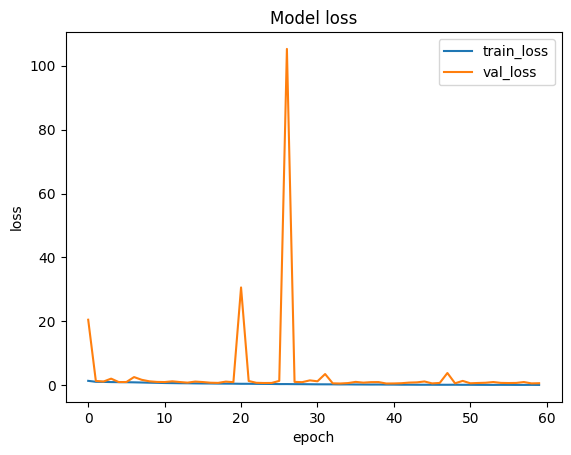

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

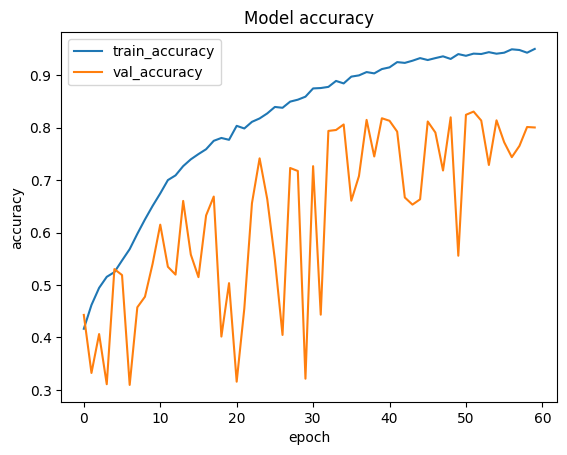

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

### Evaluation

In [40]:
resnet_34.load_weights('best_weights')

In [41]:
resnet_34.evaluate(val_dataset)

72/72 [==============================] - 5s 70ms/step - loss: 0.7331 - accuracy: 0.8306 - top_k_accuracy: 0.9495


[0.7330535054206848, 0.8305531144142151, 0.9495171308517456]

### Testing

In [43]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/112544.jpg_brightness_1.jpg")

im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)

print(CLASS_NAMES[tf.argmax(resnet_34(im), axis = -1).numpy()[0]])

happy


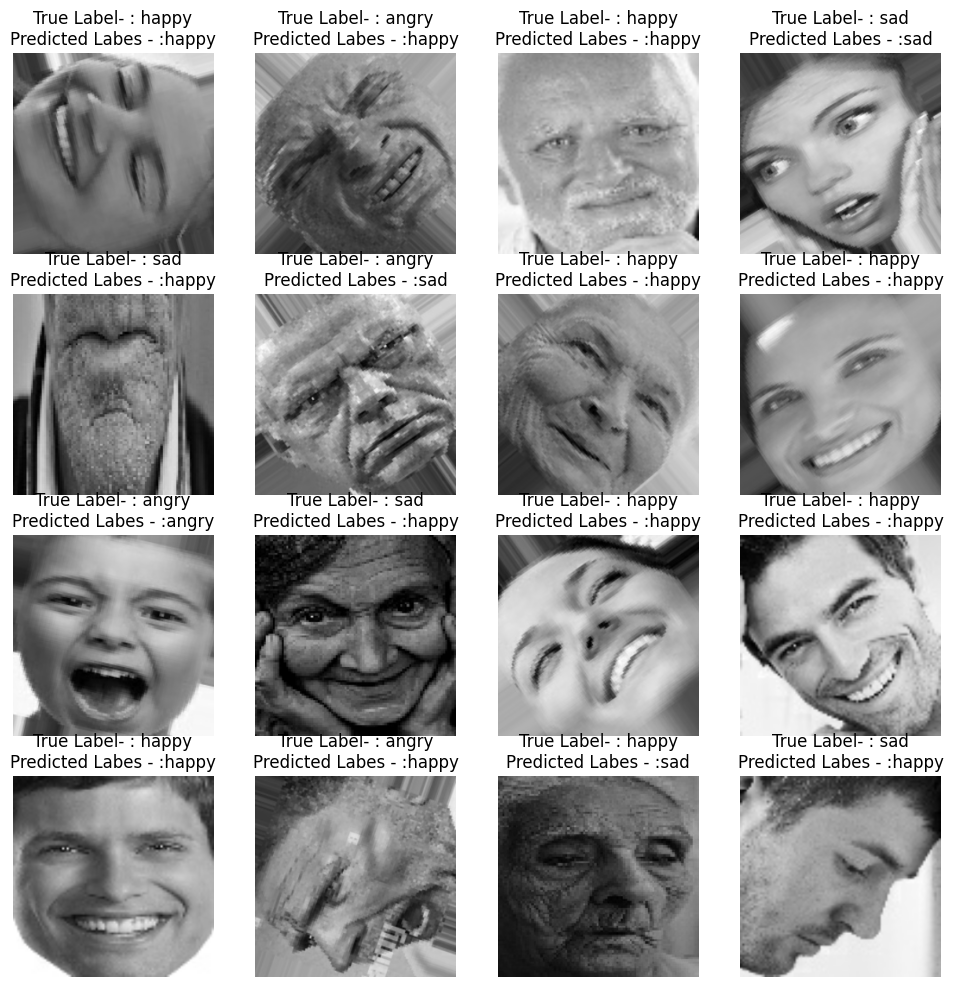

In [44]:
plt.figure(figsize = (12,12))

for images, labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Label- : " + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()] + "\n" + "Predicted Labes - :" + CLASS_NAMES[tf.argmax(resnet_34(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[-1]])
    plt.axis("off")

### Confusion Matrix

In [48]:
predicted = []
labels = []

for im, label in val_dataset:
  predicted.append(resnet_34(im))
  labels.append(label.numpy())

In [49]:
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))

[1 1 2 ... 2 1 0]
[1 1 2 ... 2 1 0]


In [50]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[419  30  66]
 [ 41 881  84]
 [ 67  60 630]]


Text(0.5, 58.7222222222222, 'Predicted')

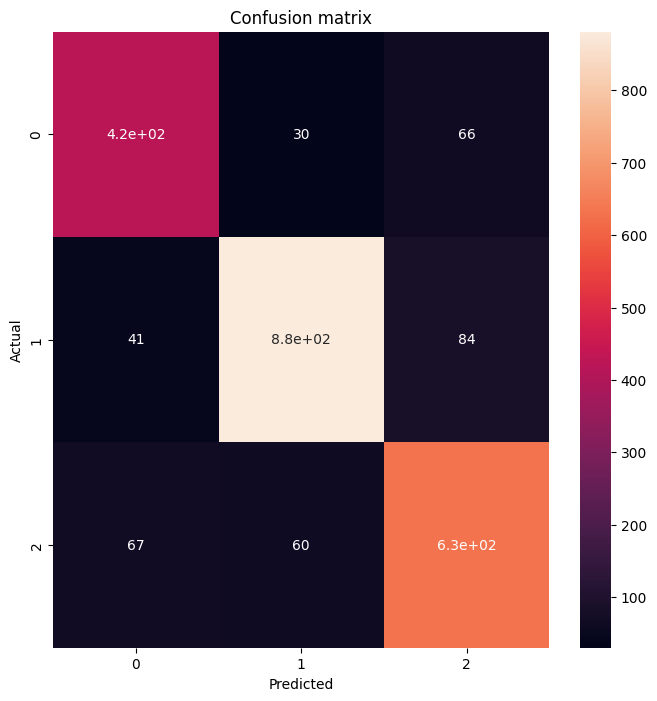

In [51]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot = True)
plt.title("Confusion matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Training

In [21]:
loss_function = CategoricalCrossentropy()

In [22]:
metrics = [CategoricalAccuracy(name = "accuracy" ), TopKCategoricalAccuracy(k = 2, name = "top_k_accuracy")]

In [23]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
    loss = loss_function,
    metrics = metrics
)

In [30]:
history = lenet_model.fit(
    training_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1
)

Epoch 1/20
213/213 [==============================] - 61s 283ms/step - loss: 0.2706 - accuracy: 0.8970 - top_k_accuracy: 0.9765 - val_loss: 0.6416 - val_accuracy: 0.7687 - val_top_k_accuracy: 0.9210
Epoch 2/20
213/213 [==============================] - 66s 306ms/step - loss: 0.2461 - accuracy: 0.9088 - top_k_accuracy: 0.9815 - val_loss: 0.6531 - val_accuracy: 0.7682 - val_top_k_accuracy: 0.9302
Epoch 3/20
213/213 [==============================] - 70s 325ms/step - loss: 0.2429 - accuracy: 0.9126 - top_k_accuracy: 0.9825 - val_loss: 0.7654 - val_accuracy: 0.7256 - val_top_k_accuracy: 0.9052
Epoch 4/20
213/213 [==============================] - 58s 271ms/step - loss: 0.2525 - accuracy: 0.9076 - top_k_accuracy: 0.9803 - val_loss: 0.6474 - val_accuracy: 0.7796 - val_top_k_accuracy: 0.9219
Epoch 5/20
213/213 [==============================] - 59s 275ms/step - loss: 0.2354 - accuracy: 0.9157 - top_k_accuracy: 0.9829 - val_loss: 0.6363 - val_accuracy: 0.7792 - val_top_k_accuracy: 0.9302
Epoch

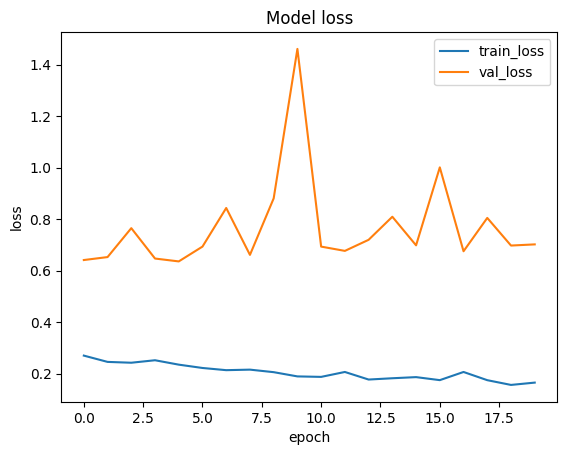

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

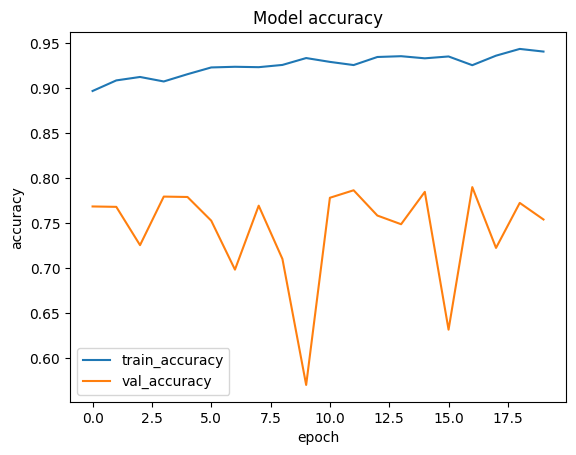

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

## Evaluation

In [33]:
lenet_model.evaluate(val_dataset)

72/72 [==============================] - 3s 41ms/step - loss: 0.7024 - accuracy: 0.7542 - top_k_accuracy: 0.9162


[0.70237797498703, 0.754170298576355, 0.9161545038223267]

## Testing

In [34]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/112544.jpg_brightness_1.jpg")

im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)

print(CLASS_NAMES[tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

happy


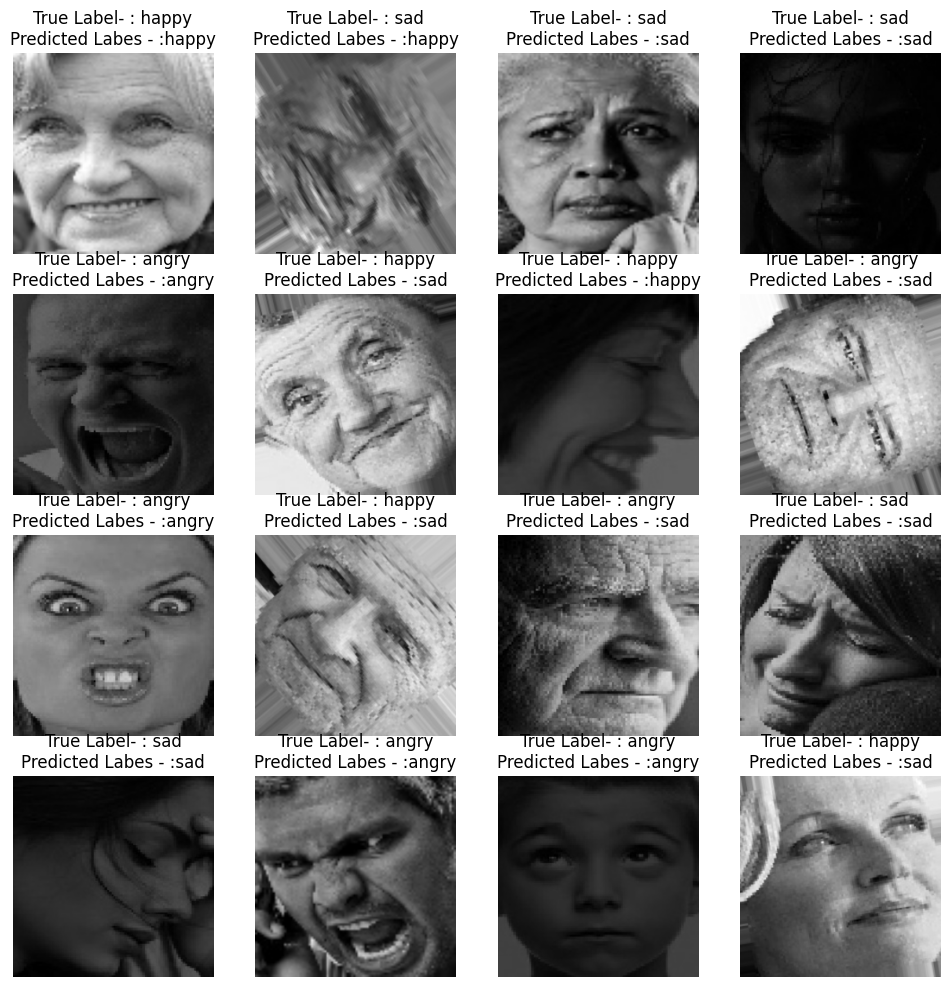

In [35]:
plt.figure(figsize = (12,12))

for images, labels in val_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Label- : " + CLASS_NAMES[tf.argmax(labels[i], axis = 0).numpy()] + "\n" + "Predicted Labes - :" + CLASS_NAMES[tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis = -1).numpy()[-1]])
    plt.axis("off")

## Confusion Matrix

In [36]:
predicted = []
labels = []

for im, label in val_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())

In [37]:
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))

[2 2 1 ... 0 1 1]
[2 2 1 ... 2 1 1]


In [38]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[326  64 125]
 [ 48 807 151]
 [ 71 101 585]]


Text(0.5, 58.7222222222222, 'Predicted')

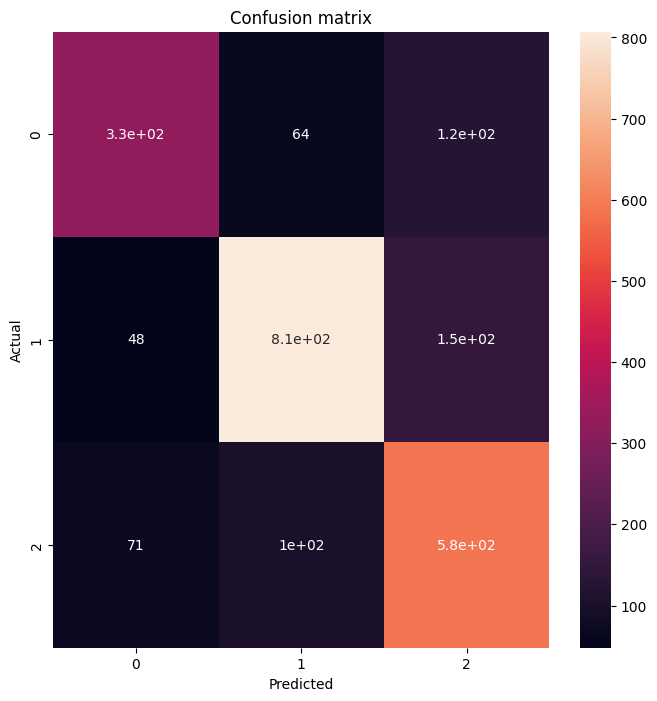

In [39]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot = True)
plt.title("Confusion matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

# TF Records


In [40]:
train_dataset = (
    training_dataset
    .unbatch()
)

In [41]:
validation_dataset = (
    val_dataset
    .unbatch()
)

In [42]:
train_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [43]:
validation_dataset

<_UnbatchDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(3,), dtype=tf.float32, name=None))>

In [44]:
def create_example(image, label):

  bytes_feature = Feature(
      bytes_list=BytesList(value=[image]))

  int_feature = Feature(
      int64_list=Int64List(value=[label]))

  example = Example(
      features=Features(feature={
          'images': bytes_feature,
          'labels': int_feature,
      }))

  return example.SerializeToString()

In [45]:
NUM_SHARDS = 10
PATH = 'tfrecords/shard_{:02d}.tfrecord'

In [46]:
def encode_image(image, label):
  image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
  image = tf.io.encode_jpeg(image)
  return image,tf.argmax(label)

In [47]:
encoded_dataset = (
  train_dataset
  .map(encode_image)
)

In [48]:
for shard_number in range(NUM_SHARDS):

  sharded_dataset = (
      encoded_dataset
      .shard(NUM_SHARDS, shard_number)
      .as_numpy_iterator()
  )

  with tf.io.TFRecordWriter(PATH.format(shard_number)) as file_writer:
    for encoded_image, encoded_label in sharded_dataset:

      example = create_example(encoded_image, encoded_label)
      file_writer.write(example)

In [49]:
recons_dataset = tf.data.TFRecordDataset(
    filenames = [PATH.format(p) for p in range(NUM_SHARDS)]
)

In [50]:
def parse_tfrecords(example):
  feature_description = {
      'images': tf.io.FixedLenFeature([], tf.string),
      'labels': tf.io.FixedLenFeature([], tf.int64),
  }

  example = tf.io.parse_single_example(example, feature_description)
  example['images'] = tf.io.decode_jpeg(example['images'], channels = 3)

  return example['images'], example['labels']


In [53]:
parsed_dataset = (
    recons_dataset
    .map(parse_tfrecords)
    .batch(CONFIGURATION["BATCH_SIZE"])
    .prefetch(tf.data.AUTOTUNE)
)

In [55]:
parsed_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
for i in parsed_dataset.take(1):
  print(i)

In [56]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Batc  (None, 254, 254, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 6)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)     

In [58]:
loss_function = tf.metrics.SparseCategoricalCrossentropy
metrics = [tf.metrics.SparseCategoricalAccuracy(name = "accuracy")]

lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)

In [ ]:
history = lenet_model.fit(
    parsed_dataset,
    #validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1,
    #class_weight = class_weights,
    #callbacks = [WandbCallback(), LogConfMatrix(), LogResultsTable()]
    )